## Test cross-correlations on GCI AK DAS data

originally by Ethan Williams 2023-03-18

modified by Marine Denolle (1/3/2024)

Import modules

In [1]:
%matplotlib inline
import os
import sys
sys.path.append('../src/')
import h5py
import numpy as np
import matplotlib.pyplot as plt
import psf_module as psf # our PSF module

# from scipy.signal import detrend, filtfilt, butter

# from obspy import UTCDateTime

Make the list of files

In [2]:
# data files
dir0='/Users/marinedenolle/homer'
fdir = dir0+'/kkfln/'
flist = np.array(os.listdir(fdir))
ftime = np.array([psf.get_tstamp(fname) for fname in flist])
index = np.argsort(np.array(ftime)-ftime[0])
flist = flist[index]
ftime = ftime[index]


Prepare cross correlation job

In [28]:

# dictionary for the Xcorr job.
recmin = 1000 # minimal source
recmax = 4000 # receiver channel
fmin = 1 # minimal frequency
fmax = 10. # maximal frequency
whiten = True # whiten the data 
onebit = True # one bit normalization
srcx = recmin # channel source location    
nns = 600 # number of time samples for the xcorr.

pdict = {'srcx': srcx, 'recmin': recmin, 'recmax': recmax, 'nns': nns, \
        'fmin': fmin, 'fmax': fmax, 'whiten': whiten, 'onebit': onebit}


In [4]:
fdir

'/Users/marinedenolle/homer/kkfln/'

In [19]:

from scipy.signal import butter, filtfilt, detrend
class simple_xc:

    def __init__(self, fdir, flist):
        self.fdir = fdir
        self.flist = [os.path.join(self.fdir, fname) for fname in flist]
        self.nf = len(self.flist)
        return

    def set_parameters(self,pdict):
        self.srcx = pdict['srcx']
        self.recmin = pdict['recmin']
        self.recmax = pdict['recmax']
        self.nns = pdict['nns']
        self.fmin = pdict['fmin']
        self.fmax = pdict['fmax']
        self.whiten = pdict['whiten']
        self.onebit = pdict['onebit']
        print('file at work',self.fdir,self.flist[0])

        with h5py.File(os.path.join(self.fdir,self.flist[0]),'r') as fp:
            self.dx = fp['Acquisition'].attrs['SpatialSamplingInterval']
            self.fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
            self.nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
            self.ns = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
        x = np.arange(self.nx)*self.dx
        print(x/1E3)
        print(self.recmin,self.recmax,self.srcx)
        r1 = int(np.argmin(abs(x-self.recmin*self.dx)))
        r2 = int(np.argmin(abs(x-self.recmax*self.dx)))
        print(r1,r2)
        self.recid = np.arange(r1, r2+1)
        self.srcid = int(np.argmin(abs(x-self.srcx*self.dx))) - r1
        self.nc = len(self.recid)
        self.nw = self.nns//2 + 1
        self.nwin = int(self.ns//self.nns)
        self.spxc = np.zeros((self.nc,self.nw),dtype=np.complex_)
        self.lags = np.arange(-self.nns//2,self.nns//2)/self.fs
        print('number of receivers', self.recid)
        print('number of receivers', self.srcid)
        print('number of dx', self.dx)
        self.offset = (self.recid - min(self.recid) - self.srcid) * self.dx
        return
    


    def preprocess_tr(self):
        '''
        this function will 1) detrend the data , 2) taper,
        3) bandpass filter, 4) fft
        '''
        self.tr = detrend(self.tr,axis=1)
        self.tr *= np.tile(np.hamming(self.nns),(self.nc,1))
        b, a = butter(8,(self.fmin/(self.fs/2),self.fmax/(self.fs/2)),'bandpass')
        self.tr = filtfilt(b,a,self.tr,axis=1)
        self.sp = np.fft.rfft(self.tr,axis=1)
        return


    def whiten_tr(self):
        '''
        this function will whiten the data by wiping out the amplitude spectrum
        '''
        i1 = int(np.ceil(self.fmin/(self.fs/self.nns)))
        i2 = int(np.ceil(self.fmax/(self.fs/self.nns)))
        self.sp[:,i1:i2] = np.exp(1j*np.angle(self.sp[:,i1:i2]))
        self.sp[:,:i1] = np.cos(np.linspace(np.pi/2,np.pi,i1))**2 * \
                                 np.exp(1j*np.angle(self.sp[:,:i1]))
        self.sp[:,i2:] = np.cos(np.linspace(np.pi,np.pi/2,self.nw-i2))**2 *\
                                 np.exp(1j*np.angle(self.sp[:,i2:]))
        return


    def onebit_tr(self):
        '''
        the function takes the sighn of the time series after it has been FFTed.
        '''
        self.tr = np.fft.irfft(self.sp,axis=1)
        self.tr = np.sign(self.tr)
        self.sp = np.fft.rfft(self.tr,axis=1)
        return


    def process_file(self,fname):
        '''
        This function readss the data from a selected number of channels (recid)
        It then preprocess , whiten and onebit the data.
        it cross correlate the entire array with the source channel (srcid)
        '''
        with h5py.File(fname,'r') as fp:
            self.data = fp['Acquisition']['Raw[0]']['RawData'][:,self.recid].T
        for iwin in range(self.nwin):
            self.tr = self.data[:,iwin*self.nns:(iwin+1)*self.nns]
            self.preprocess_tr()
            if self.whiten:
                self.whiten_tr()
            if self.onebit:
                self.onebit_tr()
            self.spxc += self.sp * np.tile(np.conj(self.sp[self.srcid,:]),(self.nc,1))
        return


    def compute_xc(self,pdict):
        self.set_parameters(pdict)
        for ii, fname in enumerate(self.flist):
            print('File %d/%d' % (ii+1,self.nf))
            self.process_file(fname)
        print(self.nf , self.nwin)
        self.spxc /= self.nf * self.nwin
        self.trxc = np.fft.irfft(self.spxc,axis=1)
        self.trxc = np.concatenate((self.trxc[:,self.nns//2:],self.trxc[:,:self.nns//2]),axis=1)
        b, a = butter(8,(self.fmin/(self.fs/2),self.fmax/(self.fs/2)),'bandpass')
        self.trxc = filtfilt(b,a,self.trxc,axis=1)
        return


In [29]:
xc = simple_xc(fdir,flist)
xc.set_parameters(pdict)
xc.compute_xc(pdict)


file at work /Users/marinedenolle/homer/kkfln/ /Users/marinedenolle/homer/kkfln/decimator2_2024-01-03_21.02.06_UTC.h5
[0.00000000e+00 9.57142881e-03 1.91428576e-02 ... 1.02041002e+02
 1.02050574e+02 1.02060145e+02]
1000 4000 1000
1000 4000
number of receivers [1000 1001 1002 ... 3998 3999 4000]
number of receivers 0
number of dx 9.571428805203961
file at work /Users/marinedenolle/homer/kkfln/ /Users/marinedenolle/homer/kkfln/decimator2_2024-01-03_21.02.06_UTC.h5
[0.00000000e+00 9.57142881e-03 1.91428576e-02 ... 1.02041002e+02
 1.02050574e+02 1.02060145e+02]
1000 4000 1000
1000 4000
number of receivers [1000 1001 1002 ... 3998 3999 4000]
number of receivers 0
number of dx 9.571428805203961
File 1/746
File 2/746
File 3/746
File 4/746
File 5/746
File 6/746
File 7/746
File 8/746
File 9/746
File 10/746
File 11/746
File 12/746
File 13/746
File 14/746
File 15/746
File 16/746
File 17/746
File 18/746
File 19/746
File 20/746
File 21/746
File 22/746
File 23/746
File 24/746
File 25/746
File 26/746

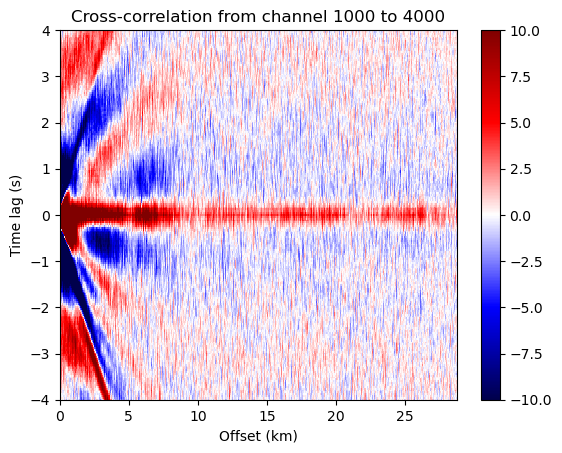

In [26]:
plt.figure(); v = 10
plt.pcolormesh(xc.offset/1E3,xc.lags,xc.trxc.T,vmin=-v,vmax=v,cmap='seismic')
plt.xlim([min(xc.offset)/1E3,max(xc.offset)/1E3])
plt.ylim([-4,4])
plt.xlabel('Offset (km)')
plt.ylabel('Time lag (s)')
plt.title('Cross-correlation from channel ' + str(recmin) + ' to ' + str(recmax ))
plt.colorbar()

In [7]:
# idx = np.logical_and(xc.offset>=0,xc.offset<=120)
# shot = xc.trxc[idx,:]
# off = xc.offset[idx]
# lag = xc.lags
# shotf = np.fft.rfft(shot,axis=1)

# vs = np.linspace(100,800,50)
# nv = len(vs)
# ns = len(lag)
# nx = len(off)
# frq = np.fft.rfftfreq(ns,d=1./fs)
# disp = np.zeros((nv,ns//2+1))
# for iv in range(nv):
#     shift = shotf.copy()
#     for ix in range(nx):
#         shift[ix,:] *= np.exp(2j*np.pi*frq*off[ix]/vs[iv])
#     disp[iv,:] = abs(np.mean(np.real(shift),axis=0))


In [8]:
# plt.figure()
# plt.pcolormesh(frq,vs,disp)
# plt.xlim([0,20])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Phase velocity (m/s)')
# plt.colorbar()

# # can also normalize
# disp /= np.tile(np.max(disp,axis=0),(nv,1))

# plt.figure()
# plt.pcolormesh(frq,vs,disp)
# plt.xlim([0,20])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Phase velocity (m/s)')
# plt.colorbar()